# A/B Testing: A Quick Tutorial

Hello! In this notebook, we will go over the full process of analyzing some simple A/B data, including formulating a hypothesis, testing that hypothesis, and interpreting the results. The dataset we will be using can be found [on Kaggle](https://www.kaggle.com/zhangluyuan/ab-testing). Here's the steps that we will go through:

1. What is A/B testing?
2. Formulating a hypothesis.
3. "Gathering" data.
4. Analyzing that data and testing our hypotheis.
5. Interpreting the results.

In [82]:
# Load in all the necesary libraries
import numpy as np
import pandas as pd
import statsmodels.stats.api as sms
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

# What is A/B Testing?

A/B testing is a statistical process to compare two (or more) versions of a variable. Each of those versions are shown to different groups in order to determine which version performs better, and if there is a statistically significant difference between them. Generally, A is the 'control' group, which is the original version of the variable, and B is the variation to the control. Let's give an example:

> Let's say we are a small business named Pear with a simple landing page. A UX designer has created a new landing page and you want to determine whether the new version would provide an increase to the overall performance of the business. The original page provided a conversion rate of 12%, and the intention is to increase the conversion rate by 3% (total of 15%). 

How do we determine if the new landing page provided the desired increase over the original? We can create an experiment where the different landing pages are the "variables," and the results are whether a person eventually bought the product. Then we can compare the original and the new version to see if there was the desired improvement.

# Formulating a Hypothesis

We want to create a hypothesis to determine whether the new webpage performed better than the old one. This hypothesis is what we want to test in a statistically rigorous way. We have two possible situations that could arise, the first is that the two webpages perform statistically the same. The first situation is the null hypothesis. The other situation is that they are statistically different. But we want to be sure that hte new webpage performs better than the old webpage. This is the alternative hypothesis. That means we will perform a [upper-tailed test](https://sphweb.bumc.bu.edu/otlt/mph-modules/bs/bs704_hypothesistest-means-proportions/bs704_hypothesistest-means-proportions3.html). Our hypotheses can be written as such:

\begin{align*}
    H_0: a_0 = a_1 \\
    H_1: a_0 < a_1
\end{align*}

where $H_0$ is our null hypothesis, $H_1$ is the alternative hypothesis, $a_0$ is the conversion rate of the original webpage, and $a_1$ is the conversion rate of the new webpage. Now, before we do any experimenting, we need to choose a signifance level $\alpha$. This is a threshold value that we set to indicate the results of the test. The test will determine a probability of observing our data, assuming that the null hypothesis is true. If that probability is less than our significance value, then we reject our null hypothesis for being too unlikely. It's common to set $\alpha=0.05$, which means that our threshold is 5% probability. The confidence of our test is $1 - 0.05 = 95\%$.

###  Designing the Test

What do we want to measure? We have two different webpages, one is the default and the other is the change, so that is our independent variable. I.e. the variable that we are changing. The value we are measuring is conversion rate, which is the dependent variable because we are testing how it changes based on the independent variable. In this case, we can code each user's decision as a binary variable. 
* 1 if the user decided to make a purchase.
* 0 if the user did not.
The conversion rate is then the mean percentage of users that made a purchase.

Knowning the number of participants that we need to get strong results is very important in A/B testing. So, how many user will we need for our survey? We won't be able to survey everyone (which would be the full population), so we need to select a sample to estimate the population. But how many people are needed to give us a good, representative sample? Well, it's a balance of two things:
* The larger the sample, the more accurate our sample will be to the overall population.
* The larger the sample, the more expensive, time-consuming and impractical it will be to collect all the data.

To figure this out, we can use something called [Power Analysis](https://machinelearningmastery.com/statistical-power-and-power-analysis-in-python/). Statistical power, or the power of a hypothesis test, is the probability that the test will correctly reject a false null hypothesis. A regular convention is to let power be $0.8$. That means that, for our experiment, if there exists an actual difference in conversion rate between the webpages, we have about an 80% chance to correctly classify that difference as statistically significant. However, there's one more piece. We need to have the correct sample size. Thankfully, using a 0.8 power, as well as our significance level ($\alpha=0.05$) and our effect size (started with 12%, want 15%), we can calculate the minimum sample size.

We can use Python's Statsmodels package to do these calculations.

In [23]:
# Initialize our desired attributes
alpha = 0.05
power = 0.8
default_rate = 0.12
new_rate = 0.15

# Convert our proportional rates to a difference in effect size
effect_size = sms.proportion_effectsize(new_rate, default_rate)

# Calculate the minimum sample size
min_sample_size = sms.TTestIndPower().solve_power(effect_size,
                                                  power=power,
                                                  alpha=alpha)
# Convert to an integer
min_sample_size = int(min_sample_size)
print(min_sample_size)

2031


We need at least 2031 observations for each group to achieve the power, alpha and effect size that we outlined. Excellent!

# "Gathering" the Data

We have all of our specifications, now it's time to actually perform the experiment. This is where we would go off and collect the data, but we're just going to use the CSV file provided to simulate the results. Let's load it in now.

In [27]:
df = pd.read_csv("ab_data.csv")
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


As with any Data Science project, it's good to explore and clean the data up before we use it. We can see from the info above that there aren't any missing values, which makes our job a bit easier. Here's some things we can do before calculating anything: 
* Remove any repeated rows.
* Drop Unneeded columns (`user_id`, `timestamp`, `landing_page`)
* Convert our independent variable to a binary variable.

In [45]:
# Make a copy of the original dataframe
df_clean = df.copy()

# Remove duplicate rows
df_clean = df_clean.drop_duplicates()
# Drop unneeded columns (user_id, timestamp)
df_clean = df_clean.drop(["user_id", "timestamp", "landing_page"], axis=1)
# Convert the `group` label to binary
df_clean["group"] = df_clean["group"].apply(lambda x: 0 if x=="control" else 1)

df_clean.head()

,group,converted
0,0,0
1,0,0
2,1,0
3,1,0
4,0,1


Now, we made the claim earlier that we only needed 2031 observations for our data. Because we're using a kaggle dataset instead of actually performing the experiment, we have many more than that. Let's create a reduced set that only uses as much data as we need from our power calculations.

In [114]:
# Randomly sample the minimum number of observations from the data
# So as not to introduce bias, we will 
df_control = df_clean[df_clean["group"] == 0].sample(min_sample_size, random_state=42)
df_treatment = df_clean[df_clean["group"] == 1].sample(min_sample_size, random_state=42)
df_small = pd.concat([df_control, df_treatment], axis=0)
# Check that we have 4062 (2031 * 2) rows
df_small.shape[0]

4062

# Analyzing the Dataset

We have our data, and it's always a good idea to do some exploratory analysis of that data. Let's calculate some descriptive statistics and make some plots!

In [115]:
# What are the conversion rates, per group?
df_summary = df_small.groupby("group").agg([np.mean, np.std])
df_summary[('converted', 'std.err')] = df_summary[('converted', 'std')] / np.sqrt(min_sample_size*2)
df_summary

converted                    
           mean       std   std.err
group                              
0      0.131462  0.337989  0.005303
1      0.114229  0.318168  0.004992

From the descriptive statistics, it looks like the two groups performed very similarly. In fact, the control group appears to perform slightly better than the treatment group. Which isn't good news for our hypothesis. We can also make a visual representation of the conversion rate.

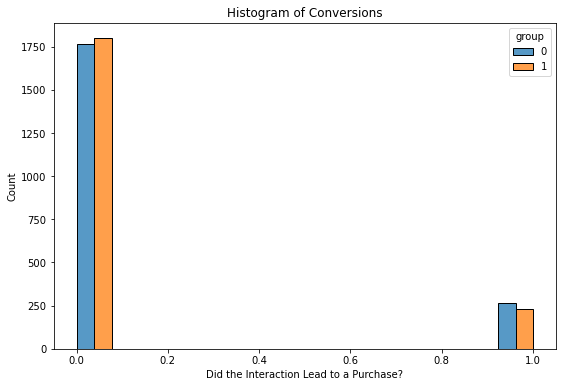

In [116]:
fig, ax = plt.subplots(1, 1, figsize=(9, 6))
sns.histplot(df_small, x="converted", hue="group", multiple="dodge", ax=ax)
ax.set_title("Histogram of Conversions")
ax.set_xlabel("Did the Interaction Lead to a Purchase?");

The plot shows a similar result, that the counts between the two are very similar, and that more customers purchased an object in the control group versus the treatment group.

We've taken some initial inspections, now let's actually do the calculations to test our hypothesis. Remember, we are testing the hypothesis that the treatment group has a conversion rate that is statistically greater than the conversion rate of the control group, at a 95% confidence level.

There are two main ways we can test this hypothesis:
1. Confidence Intervals: Each group has a convserion score, which is an estimation of the "true" conversion score of the entire population. We can determine the range of conversion scores that each group is likely to fall within, given our significance level. This range is called a Confidence Interval (CI). If the CI of the control group's conversion score overlaps with the CI of the treatment group's conversion score, then we fail to reject the null hypothesis. I.e. the two groups do not have statistically different conversion rates.

In [122]:
# We need to calculate the CI for the difference between proportions.
# To do that, we can follow this formula: p +- z_alpha * sqrt(p(1-p)/n)
# Where z_alpha is the z-critical value based on our confidence level
# p is the proportion of our group (in our case, the conversion rate)
# n is the sample size

# Calculate z-critical value for 95% confidence
z = stats.norm.ppf(1 - alpha/2)

# Initialize our convsersion rates and n_sample values
n_control = len(df_small.loc[df_small["group"]==0])
n_treat = len(df_small.loc[df_small["group"]==1])
conv_control = np.mean(df_small.loc[df_small["group"]==0]["converted"])
conv_treat = np.mean(df_small.loc[df_small["group"]==1]["converted"])

# Calculate the Confidence Intervals
ci_control = [conv_control-z*np.sqrt(conv_control*(1-conv_control)/n_control), \
              conv_control+z*np.sqrt(conv_control*(1-conv_control)/n_control)]
ci_treat = [conv_treat-z*np.sqrt(conv_treat*(1-conv_treat)/n_treat), \
              conv_treat+z*np.sqrt(conv_treat*(1-conv_treat)/n_treat)]

print("Conversion Rate CI for Control Group: {}".format(ci_control))
print("Conversion Rate CI for Treatment Group: {}".format(ci_treat))

Conversion Rate CI for Control Group: [0.11676670659939874, 0.14615796105200451]
Conversion Rate CI for Treatment Group: [0.10039560261596504, 0.1280632846316962]


In [123]:
# We can check our values against a builtin package's CI calculator
from statsmodels.stats.proportion import proportion_confint

successes = [df_small.loc[df_small["group"]==0]["converted"].sum(), df_small.loc[df_small["group"]==1]["converted"].sum()]
n_samples = [n_control, n_treat]
(control_lower, treat_lower), (control_upper, treat_upper) = proportion_confint(successes, nobs=n_samples, alpha=0.05)

print("Control Group:", [control_lower, control_upper])
print("Treatment Group:", [treat_lower, treat_upper])

Control Group: [0.11676670659939874, 0.14615796105200454]
Treatment Group: [0.10039560261596504, 0.1280632846316962]


2. P-values: We can calculate the probability of observing our treatment data, or more extreme data, assuming our null hypothesis is true. If the probability is very small (less than our significance of 0.05), then we reject the null hypothesis. If it is not, then we fail to reject the null hypothesis. We can calculate this probability using a Z-test, because we have a large number of samples, thanks to the Central Limit Theorem.

In [124]:
# We can use existing methods to calculate a Z-test
from statsmodels.stats.proportion import proportions_ztest

z_stat, pval = proportions_ztest(successes, nobs=n_samples, alternative="smaller")
print("P-Value:", pval)

P-Value: 0.9528302390397035


# Interpreting the Results

We've performed statistics! But what do the numbers mean? Well, both tests give us the same answer that we failed to reject the null hypothesis.

1. The CI for conversion rates overlap, meaning that we reject the null hypothesis. We can also see that the treatment group contained a conversion rate of 0.12, and did not contain the 0.15 conversion rate we where looking for.
2. The P-value we calculated is much larger than our significance value (0.952 > 0.05).

From these results, we fail to reject the null hypothesis. Therefor, we conclude that the treatment group (and thus the new version of the webpage) does not provide a statistically significant improvement over the control group, let alone the 3% increase that we wanted.

# Bonus Section: Considerations

While the results of the A/B test are clear, real life situations are rarely as clearcut as this example. There are many other things that are worth considering when designing a test and interpreting the results.

1. Time can play a significant role in metrics. If group A is asked to buy something during the holiday season, and group B is asked after the season, then that can affect the results of the study. This is just one example, but it's not hard to imagine other examples of time of day, weekday vs. weekend, and seasonality affecting whether a user's visit ends in a sale.
2. There may be engineering costs, opportunity costs, maintenance, etc. that are not strictly accounted for in an A/B test. These costs should be factored into a final decision of whether a change is worth it.
3. Users may be used to the old design, and may need some time to get used to a completely new webpage. This can be difficult to account for with a A/B tests, which largely account for short-term changes.
4. It's always important to question to validity of the data, as that could disrupt the conclusions made from statistical tests. Was there potential interference between the groups? Was one group affected by bugs that the other wasn't? 
5. In the end, humans are complicated. An A/B test is a statistical tool to make informed decisions, but they are not law. If a test says one thing, but you are certain that you should do a different thing, then go for it!

That's it. Thank you for reading this short tutorial on A/B testing!